# Companion code for "Persistent homology based computed tomography measurements of fibrosis and emphysema in lung diseases"

- Input data file: volume data should be prepared in the dicom format or the numpy format (.npz)
-- the npz file should be placed under the directory specified by root_npy
-- the dicom series should be placed under a single directory under the directory specified by root_npy

In [1]:
#install necessary packages if you do not have them
!pip install persim ipywidgets
!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim

In [3]:
## This program requires a lot of (GPU) memory.
## Restart the kernel when you get "out of memory" errors.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import os,time,subprocess,glob,re,pandas
from scipy.ndimage.filters import convolve
import ipywidgets as ipyw
import seaborn as sns
from lung_whole_batch import *
np.set_printoptions(precision=5,suppress=True)

## Function definition

In [4]:
# display volumetric image
class ImageSliceViewer3D: # originally from https://github.com/mohakpatel/ImageSliceViewer3D
    def __init__(self, vols, figsize=(40,20), vmin=None, vmax=None, init_z=0, colour=False, cmap=None, title=None, save=None, save_exit=False):
        self.vols = vols
        self.save=save
        self.title=title
        self.save_exit=save_exit
#        print(vols[0].shape)
        if type(vols) is not list:
            if(len(vols.shape)==3):
                self.vols = [vols]
        n = len(vols)
        self.init_z = init_z
        self.figsize = figsize
        self.colour=colour
        self.view = [1,2,3,0] if self.colour else [0,1,2]
        self.cmap = ['gray' for i in range(len(vols))] if cmap is None else cmap*n
        self.vmin = [np.min(vols[i]) for i in range(n)] if vmin is None else vmin*n
        self.vmax = [np.max(vols[i]) for i in range(n)] if vmax is None else vmax*n
        
        if vols[0].shape[-1]>1:
            ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
                options=['x-y','y-z', 'z-x'], value='x-y', 
                description='Slice plane selection:', disabled=False,
                style={'description_width': 'initial'}))
        else:
            self.plot_slice(0)
            
    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        if self.colour:            
            orient = {"y-z":[2,3,1,0], "z-x":[3,1,2,0], "x-y": [1,2,3,0]}
        else:
            orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
            
        self.view = orient[view]
        maxZ = self.vols[0].shape[self.view[2]] - 1
        
        # Call to view a slice within the selected slice plane
        ipyw.interact(self.plot_slice, 
            z=ipyw.IntSlider(value=self.init_z, min=0, max=maxZ, step=1, continuous_update=False, 
            description='Image Slice:'))
        
    def plot_slice(self, z):            
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
        n = len(self.vols)
        for i in range(n):
            ax = plt.subplot(1,n,i+1)
            ax.axis('off')
            if self.title is not None:
                ax.set_title(self.title[i], fontsize=30)
            if(self.colour and len(self.vols[i].shape)==4):
                ax.imshow( (np.clip(self.vols[i].transpose(self.view)[:,:,z,:],self.vmin[i],self.vmax[i])-self.vmin[i])/(self.vmax[i]-self.vmin[i]) )
            else:
                ax.imshow( np.clip(self.vols[i].transpose(self.view)[:,:,z],self.vmin[i],self.vmax[i]),cmap=plt.get_cmap(self.cmap[i]),vmin=self.vmin[i], vmax=self.vmax[i])      
        if self.save is not None:
            plt.savefig(self.save)
            if self.save_exit:
                return
            self.save=None


In [5]:
# plot persistence diagram
def PDView(pd,cond,bmin=-2100,bmax=1200,zmin=0,zmax=9999,save_fn=None,size=3):
    import persim
    import matplotlib.colors as mcolors

    bluea = (mcolors.to_rgb("tab:blue") + (0.01,),)
    orangea = (mcolors.to_rgb("tab:orange") + (0.01,),)
    greena = (mcolors.to_rgb("tab:green") + (0.01,),)

    plt.figure(figsize=(24,20))
    
    # select cycles to plot
    ppd = [pd[ (pd[:,0]==d)*(zmin<=pd[:,5])*(pd[:,5]<=zmax),1:3] for d in range(3)]
    line_style=['-','--']*len(cond)

    for i,f in enumerate(cond):
        ax = plt.subplot(1,len(cond),i+1)
        persim.plot_diagrams(ppd[f['dim']],ax=ax,xy_range=[bmin,bmax,bmin,bmax],legend=True, size=size, labels=['$H_{}$'.format(f['dim'])])
        ax.plot([f['b0'],f['b1']], [f['b0']+f['l0'],f['b1']+f['l0']], line_style[i], c="r")
        ax.plot([f['b0'],f['b0']], [f['b0']+f['l0'],min(bmax-100,f['b0']+f['l1'])], line_style[i], c="r")
        ax.plot([f['b1'],f['b1']], [f['b1']+f['l0'],min(bmax-100,f['b1']+f['l1'])], line_style[i], c="r")
        ax.plot([f['b0'],f['b1']], [min(bmax-100,f['b0']+f['l1']),min(bmax-100,f['b1']+f['l1'])], line_style[i], c="r")

    if save_fn:
        plt.savefig(save_fn)
    plt.show()

## Setting

In [7]:
## characteristic cycles
# cycles of 'dim' with birth time between b0 through b1, death time between d0 through d1, lifetime between l0 through l1 will be counted
# and those voxels with density higher than th will be visualized
cond = [
         {'name': 'fib', 'dim': 0, 'b0':-1260, 'b1':-380, 'd0': -5000, 'd1': 5000, 'l0': 360, 'l1': 5000, 'th': 1}, 
         {'name': 'emp', 'dim': 2, 'b0':-1020, 'b1':-900, 'd0': -5000, 'd1': 5000, 'l0': 20, 'l1': 90, 'th': 8.3},
       ]

th_def = [f['th'] for f in cond]

## GPU
gpu_id = 0 ## use the first gpu on the system
#gpu_id = -1   ## in case you do not have one

## the directory containing all data files
#root_npy = os.path.expanduser("~/ipf/FinalSegmentation60cases/")
root_npy = os.path.expanduser("~/DICOMs/")

## filename and the z-slice to be focused
#name, init_z="PD20813300segmentedfinal", 381
#name, init_z="IPF083segmentedfinal", 253
name, init_z="Tosei_case1_time0", 0


## labelling (optional)
data_fn = "idlista.csv"
if os.path.isfile(data_fn):
    dat = pandas.read_csv(data_fn,header=0)
    names = dat['name'].tolist()
    label = dat.at[names.index(name),'label']
else:
    label = "unknown"

## characteristic cycle and gaussian kernel parameter
#cycle_data_suffix, sigma, h = "_cyc200922.npz", 5.0, 25
cycle_data_suffix, sigma, h = "_cyc200930.npz", 10.0, 12

## focus on a spefic z-range for efficiency
#z_crop = (init_z-2*h, init_z+2*h)
z_crop = None   # process the whole volume

## flag to recompute characteristic cycles based on "cond"
recompute_cycle_norm = True

print("characteristic cycles: ",cond)
if not os.path.isdir(root_npy):
    print("set root_npy correctly!")
print("npy dir: ",root_npy)


characteristic cycles:  [{'name': 'fib', 'dim': 0, 'b0': -1260, 'b1': -380, 'd0': -5000, 'd1': 5000, 'l0': 360, 'l1': 5000, 'th': 1}, {'name': 'emp', 'dim': 2, 'b0': -1020, 'b1': -900, 'd0': -5000, 'd1': 5000, 'l0': 20, 'l1': 90, 'th': 8.3}]
npy dir:  /home/skaji/DICOMs/


## Main

In [8]:
## load/compute volume, persistent homology, cycle density
## results will be cached under root_npy. remove the cache files if you want to recompute.

print("loading... ",name, label, z_crop)
base_fn = os.path.join(root_npy,name)

vol = load_vol(base_fn+".npz",z_crop=z_crop)
pd = load_pd(base_fn,vol=vol,z_crop=z_crop)
nn_vol = load_vol(base_fn+"_NN1.npz",z_crop=z_crop)
if nn_vol is None:
    nn_vol = np.zeros_like(vol)
else:
    nn_vol = nn_vol.astype(np.float32)
print("Volume: ",vol.shape," PD: ",pd.shape)

recompute_data = {'vol': vol, 'pd': pd, 'cond': cond, 'h':h, 'sigma':sigma, 'gpu_id': gpu_id, 'force': recompute_cycle_norm}
cycle_norm = load_cyc(base_fn+cycle_data_suffix,recompute=recompute_data,z_crop=z_crop,verbose=True)
stats = volume_stat(vol,cycle_norm, th_def)
st = ["vol",cond[0]['name'],cond[1]['name'],cond[0]['name']+"_ratio",cond[1]['name']+"_ratio",cond[0]['name']+"_99%",cond[1]['name']+"_99%",
      cond[0]['name']+"%>th",cond[1]['name']+"%>th","HAA%","LAA%"]
for s,ff in zip(st,stats):
    print(s,"\t\t",ff)
    
#stats = volume_stat(vol,nn_vol, [0.5,0.5])
#st = ["fib_NN_ratio","emp_NN_ratio","fib_NN_99%","fib_NN_99%","emp_NN%>0.5","emp_NN%>0.5"]
#for s,ff in zip(st,stats[3:-2]):
#    print(s,"\t\t",ff)


loading...  Tosei_case1_time0 unknown None
saving the volume to npz...
computing PH...
file not found.
Volume:  (512, 512, 654)  PD:  (2499539, 9)
couting relevant cycles...
computing cycle heatmap...
cycle heatmap computed
elapsed_time:5773.504161119461 sec
vol 		 11617837.0
fib 		 9835270.0
emp 		 197817.52
fib_ratio 		 0.8465664
emp_ratio 		 0.017027052
fib_99% 		 9.811588
emp_99% 		 0.6636503
fib%>th 		 0.20928474
emp%>th 		 3.7012053e-06
HAA% 		 0.07293836
LAA% 		 0.07470039


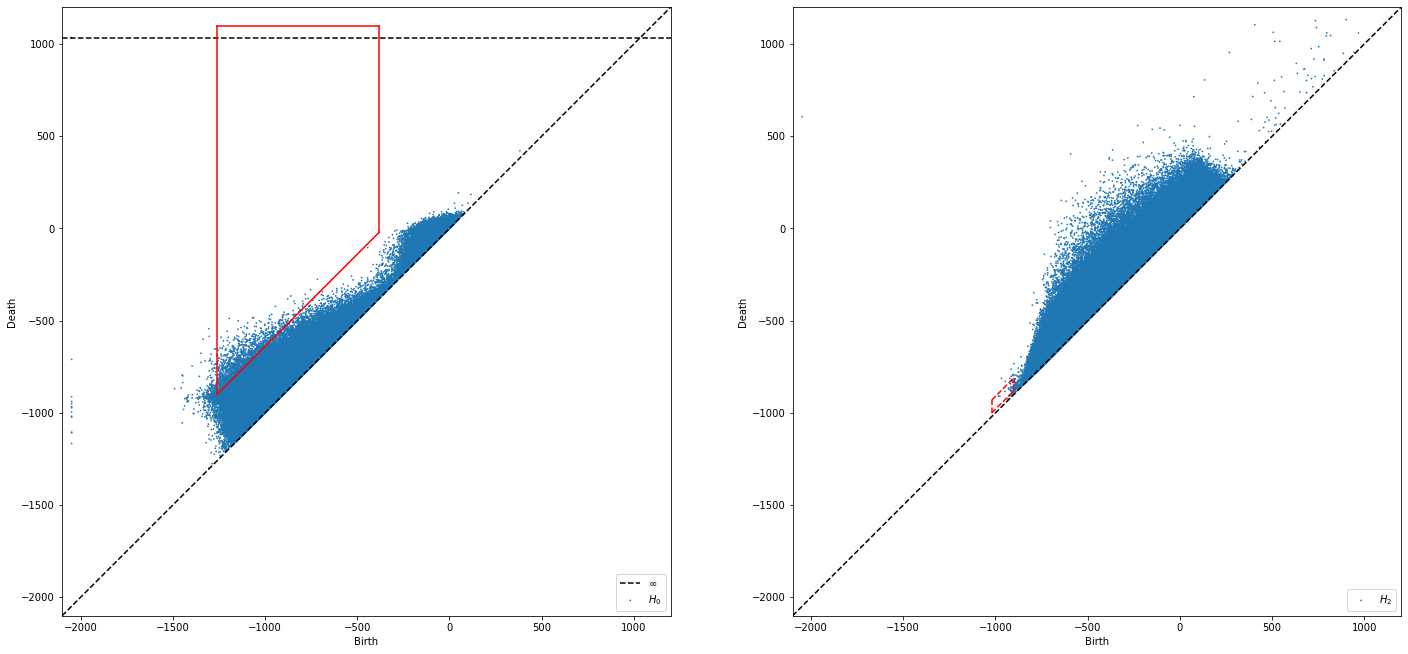

In [9]:
# persistence diagram
PDView(pd,cond,save_fn="PD_"+name+".jpg")
#PDView(pd,cond,zmin=init_z-20,zmax=init_z+20)

In [10]:
# visualise pixels above/below threshold values (overlay)
print(name,label)    
th_nn = [0.5,0.5]
th = th_def

if z_crop:
    zz = (z_crop[1]-z_crop[0])//2
else:
    zz = init_z

_ = ImageSliceViewer3D([np.stack([vol,vol,vol]), # original CT
                    np.stack([vol+500*(cycle_norm[0]>th[0]),vol,vol+800*(cycle_norm[1]>th[1])*(cycle_norm[0]<=th[0])]),  # PH
                    np.stack([vol+500*(nn_vol[0]>th_nn[0]),vol,vol+800*(nn_vol[1]>th_nn[1])]), ## NN
                    np.stack([vol+500*(vol>-200),vol,vol+800*(-2048<vol)*(vol<-950)]), ## LAA/HAA
                   ],
                   title=["CT","PH","NN","AA"],
                   init_z=zz, vmin=[-1000],vmax=[500],colour=True,save="{}_z{}.jpg".format(name,init_z))

Tosei_case1_time0 unknown


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [ ]:
# visualise a single slice
th = th_def

print(name,label, "z={}".format(init_z))    
if z_crop:
    zz = (z_crop[1]-z_crop[0])//2
else:
    zz = init_z

v=vol[:,:,[zz]]
_ = ImageSliceViewer3D([np.stack([v,v,v]),
                    np.stack([v+500*(cycle_norm[0,:,:,zz:(zz+1)]>th[0]),v,v+800*(cycle_norm[1,:,:,zz:(zz+1)]>th[1])*(cycle_norm[0,:,:,zz:(zz+1)]<=th[0])]),
                    np.stack([v+500*(v>-200),v,v+800*(-2048<v)*(v<-950)]),
                   ], title=["CT","PH","AA"],
                   vmin=[-1000],vmax=[500],colour=True)

In [ ]:
# visualise pixels above/below threshold values (replace)
base_vol = (np.clip(np.stack([vol,vol,vol]),-1000,500)+1000)/1500
PHmarked_vol = np.stack([cycle_norm[0]>th[0],np.zeros_like(cycle_norm[0]),cycle_norm[1]>th[1]])
PHmarked_vol = np.where(np.max(PHmarked_vol,axis=0)>0, PHmarked_vol, base_vol)
HUmarked_vol = np.stack([vol>-200,np.zeros_like(cycle_norm[0]),np.logical_and(-2048<vol,vol<-950)])
HUmarked_vol = np.where(np.max(HUmarked_vol,axis=0)>0, HUmarked_vol, base_vol)

_ = ImageSliceViewer3D([base_vol,PHmarked_vol,HUmarked_vol],init_z=init_z, colour=True)


In [11]:
# visualise pixel values (separately)
# set vmin and vmax for viewing level window
# choose cmap from https://matplotlib.org/examples/color/colormaps_reference.html
_ = ImageSliceViewer3D([vol,cycle_norm[0],cycle_norm[1]],vmin=[-1000,0,0,0],title=["CT","fib","emp"],
                       init_z=init_z,cmap=['gray','Reds','Reds'])

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

99 percentile:  9.811587867736833
99 percentile:  0.6636502742767334


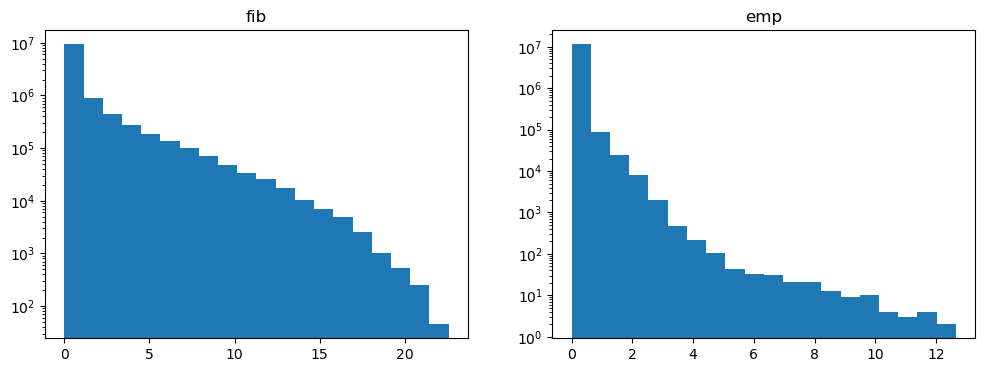

In [12]:
# histgram of cycle density
in_cycle = cycle_norm[:,vol>-2048]
plt.figure(figsize=(12,4))
for i,a in enumerate(in_cycle):
    ax = plt.subplot(1,len(in_cycle),i+1)
    ax.hist(a.flatten(),bins=20, log=True)
    ax.set_title(cond[i]['name'])
    print("99 percentile: ", np.percentile(a, 99))

## Comparison of segmentation

In [ ]:
## visualise and compute DICE for segmentation results
from sklearn.metrics import jaccard_score

root_label ="label_image/testB"
models = ["PH25","PH50","NN1","AA"]
names = [os.path.splitext(os.path.splitext(fname)[0])[0] for fname in sorted(os.listdir(root_label)) if fname.endswith(".npy")]
names = ["IPF144segmentedfinal_405","PD20813300segmentedfinal_382"]  ## for figure in the paper
## computation for DICE
#names = ["IPF030segmentedfinal_438","IPF035segmentedfinal_436","IPF083segmentedfinal_480","IPF109segmentedfinal_457","IPF147segmentedfinal_431","IPF148segmentedfinal_377","IPF153segmentedfinal_474","IPF179segmentedfinal_495","MD003001segmentedfinal_405","MD004202segmentedfinal_485","MD006001segmentedfinal_262","MD006901segmentedfinal_343","PD20613093segmentedfinal_317","PD20813300segmentedfinal_382"]
n_class=3

root_save = "label_image/comparison"
os.makedirs(root_save, exist_ok=True)

th25 = th_def  # ROI25
th50 = [0.4,40]    # ROI50
th_aa = [700,2200] # HAA/LAA
th_nn = [0.5,0.5]  # NN
h, sigma = 12, 10

dices = np.zeros((len(names),15))

for k,fns in enumerate(names):
    print(k,fns)
    fn = fns[:-4]
    init_z = int(fns[-3:])
    z_crop = (init_z-int(1.3*h), init_z+int(1.3*h))
    zz = (z_crop[1]-z_crop[0])//2

    save_fn = os.path.join(root_save,"{}_{}.jpg".format(fn,init_z))
    base_fn=os.path.join(root_npy,fn)
    vol = load_vol(base_fn+".npz",z_crop=z_crop)
    pd = load_pd(base_fn,z_crop=z_crop)
    v = vol[:,:,[zz]]
    
    cycle_25 = load_cyc(base_fn+"_cyc200930.npz",z_crop=z_crop)[:,:,:,[zz]]   
    PH25 = np.zeros_like(v)
    PH25[cycle_25[1,:,:]>th25[1]] = 1    
    PH25[cycle_25[0,:,:]>th25[0]] = 2

    cycle_50 = load_cyc(base_fn+"_cyc200922.npz",z_crop=z_crop)[:,:,:,[zz]]
    PH50 = np.zeros_like(v)
    PH50[cycle_50[1,:,:]>th50[1]] = 1    
    PH50[cycle_50[0,:,:]>th50[0]] = 2    
    
    nn_vol = load_vol(base_fn+"_NN1.npz",z_crop=z_crop)[:,:,:,[zz]].astype(np.float32)
    NN1 = np.zeros_like(v)
    NN1[nn_vol[1,:,:]>th_nn[1]] = 1    
    NN1[nn_vol[0,:,:]>th_nn[0]] = 2    

    #NN2 = np.load(os.path.join(root_NN2,fns)+".npy")[:,:,np.newaxis]
    
    kernel = gaussian(h,sigma)
    aa = conv_channel(np.stack([(v>-200),(-2048<v)*(v<-950)]).astype(np.float32), vol, kernel,verbose=False)[:,:,:,[zz]]
    AA = np.zeros_like(v)
    AA[aa[1]>th_aa[1]] = 1    
    AA[aa[0]>th_aa[0]] = 2    
#    AA[(-2048<v)*(v<-950)] = 1
#    AA[(v>-200)] = 2
    
    manual = np.load(os.path.join(root_label,fns)+".npy")[:,:,np.newaxis]        
    
    print("Volume: ",v.shape)

    _ = ImageSliceViewer3D([  #np.stack([v,v,v]),
                        np.stack([v+500*(manual==2),v,v+800*(manual==1)]),                            
                        np.stack([v+500*(PH25==2),v,v+800*(PH25==1)]),
                        np.stack([v+500*(PH50==2),v,v+800*(PH50==1)]),
                        np.stack([v+500*(NN1==2),v,v+800*(NN1==1)]),                            
#                        np.stack([v+500*(NN2==2),v,v+800*(NN2==1)]),                            
                       np.stack([v+500*(AA==2),v,v+800*(AA==1)]),
                       ],
                       title=["Manual"]+models,
                       vmin=[-1000]*8,vmax=[500]*8,
                           figsize=(100,20),colour=True,save=save_fn,save_exit=True)
    if len(names)>3:
        plt.close()
    
    t_label = manual[v>-2048].flatten()
    for i,lb in enumerate([PH25,PH50,NN1,AA]):
        for j in range(n_class):
            dices[k,n_class*i+j] = jaccard_score(t_label==j,lb[v>-2048].flatten()==j)
    print("DICE: ",dices[k])

## write dice scores to file
dic = {'name': names}
k=0
for dn in models:
    for i in range(n_class):
        dic[dn+"_{}".format(i)] = dices[:,k]
        k +=1
df = pandas.DataFrame.from_dict(dic)
df.to_csv("dice_NN.csv",index=False)

## plot dice
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=1.0, hspace=0.6)
for i in range(n_class):
    ax = fig.add_subplot(1, n_class, i+1)
    ax.violinplot([dic[dn+"_{}".format(i)] for dn in models])
    ax.set_xticks([k+1 for k in range(len(models))])
    ax.set_xticklabels(models)
    ax.set_xlabel('Method')
    ax.set_ylabel('DICE for label {}'.format(i))
    ax.set_ylim(0, 1)
plt.savefig("dice.jpg")


## Utility

In [ ]:
## Gaussian kernel visualisation
h, sigma=12, 9.0
g= gaussian(h,sigma)
print(g.shape, g[h,0,h],g[h,h,h],np.sum(g))
mappable = plt.imshow(g[:,:,h])
plt.colorbar(mappable)

In [ ]:
## memory usage
import psutil 
mem = psutil.virtual_memory() 
print(mem.used/(1024**2),mem.total/(1024**2),mem.available/(1024**2))